# M09-Desafío EPEC: Modelado y Optimización de Hábitos de Consumo de Energía Eléctrica 24

Práctico Nro 1

## 1.- Entender el dominio

La energía eléctrica es un servicio fundamental que permite el desarrollo de toda actividad humana. En general existen roles bien definidos en este mercado, hay generadores que están en condiciones de generar una cantidad de energía grande pero no ilimitada, hay transportistas que vinculan los generadores con los centros de consumo, y distruidores que reciben la energía y cuyo rol es lograr la capilaridad necesaria para vincular todos los usuarios a la red. El servicio de distribución es un monopolio natural prestado por distribuidoras que reciben un área de servicio exclusivo. Es función controlar las condiciones de calidad adecuadas a cada usuario y medir su consumo, esto es mantener la red balanceada y la potencia de cada eslabón dentro de los parámetros admisibles por los equipos (estaciones de transformación).

Siempre debe existir un equilibrio entre la energía eléctrica de generada y la consumida. Considerando el costo incremental y la dificultad que conlleva tener fuentes de generación flexibles, resulta interesante poder hacer una predicción lo más certera posible de las condiciones de demanda futura para poder pogramar el despacho de energía desde diferentes generadores.

La tarifa es la señal con la que cuenta el distribuidor para modelar la demanda. La tarifa puede variar por horario de consumo, pero también por tipo de consumir. La forma en que el usuario recibe esta "señal" es la factura, imagen que vemos aquí. 

Nuestro dataset contiene los datos esenciales agregados de todos los consumidores de un distribuidor determinado para el año 2023.


![alt text](https://ersep.cba.gov.ar/wp-content/uploads/2019/09/factura-Epec-frente-.jpg)

## 2.- Comenzar a responder algunas preguntas que nos podemos hacer como Data Scientist

Los datos fueron recibidos en un único archivo ''Clou_diario_diplo.rar''. Y se compone de diferentes datasets los cuales serán cargados en este notebook con las siguientes denominaciones:
* **consumos**: varios archivos con el registro mensual de los consumos y extensión ''*FINAL.csv''.
* **qgis**: ''QGIS_final.csv'' con los datos básicos del consumidor.
* **clima**: ''clima.txt'' un archivo con información de la condiciones del clima para diferentes estaciones metereológicas del país.
* **observatorio**: ''CORDOBA OBSERVATORIO.txt'' un archivo con información meterológica de diferentes variables para limitado a un área geográfica.

### 2.a. ETL

#### Carga de librerías necesarias para ETL

In [100]:
import glob
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

#### Carga de datasets
Consumos:

In [3]:
# Son archivos mensuales CSV con ; como separador
archivos_cargados=[]

# Construcción del dataframe
consumos= pd.DataFrame()

# Carga de las lecturas mensuales de consumos
for each_file in glob.glob('*FINAL.csv'):
    archivos_cargados.append(each_file)
    datos_mes = pd.read_csv(each_file, sep=";", decimal=',')
    consumos = pd.concat([consumos, datos_mes])

QGIS:

In [4]:
# Es un archivo CSV con ; como separador
qgis = pd.read_csv('QGIS_final.csv', sep=";", decimal=',')

Clima:

In [5]:
# Es un archivo de texto de ancho fijo
col_widths = [8, 6, 6, 40]

# Columnas disponibles
column_names = ['FECHA', 'TMAX', 'TMIN', 'NOMBRE']

# Nombre del archivo
file_path = 'clima.txt'

# Carga
clima = pd.read_fwf(file_path, widths=col_widths, names=column_names, header=None)

# Nos quedamos solo con mediciones de Córdoba (zona geográfica de nuestro distribuidor)
clima = clima.loc[clima['NOMBRE'].str.contains('CORDOBA')]

Observario:

In [6]:
# Es un archivo de texto con múltiples datos metereológicos. Las precipitaciones contienen además comentarios que debemos 'bypasear' antes de su carga
precipitaciones = pd.read_csv('CORDOBA OBSERVATORIO.txt', sep=";", decimal=',', encoding ='latin1', skiprows=5, nrows=31)

# Se elimina columna sin datos creada automáticamente
precipitaciones.drop('Unnamed: 13', axis=1, inplace=True)

In [7]:
# Es un archivo de texto con múltiples datos metereológicos. Las temperaturas contienen además comentarios
temperatura_max = pd.read_csv('CORDOBA OBSERVATORIO.txt', sep=";", decimal=',', encoding ='latin1', skiprows=44, nrows=31)

# Se elimina columna sin datos creada automáticamente
temperatura_max.drop('Unnamed: 13', axis=1, inplace=True)

In [8]:
# Es un archivo de texto con múltiples datos metereológicos. Las temperaturas contienen además comentarios
temperatura_min = pd.read_csv('CORDOBA OBSERVATORIO.txt', sep=";", decimal=',', encoding ='latin1', skiprows=82, nrows=31)

# Se elimina columna sin datos creada automáticamente
temperatura_min.drop('Unnamed: 13', axis=1, inplace=True)

In [9]:
# Es un archivo de texto con múltiples datos metereológicos. Las temperaturas contienen además comentarios
temperatura_avg = pd.read_csv('CORDOBA OBSERVATORIO.txt', sep=";", decimal=',', encoding ='latin1', skiprows=120, nrows=31)

# Se elimina columna sin datos creada automáticamente
temperatura_avg.drop('Unnamed: 13', axis=1, inplace=True)

#### 2.b. Observación inicial de los datos disponibles

In [10]:
consumos.head()

,DEVICE,TV,UPDATE_TV,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,...,VALUE18,VALUE19,VALUE20,VALUE21,VALUE22,VALUE23,VALUE24,VALUE25,VALUE26,RN
0,0,01/03/2023,01/03/2023,NaN,1923.249,1923.249,986.267,476.932,460.050,0.0,...,0.0,0.976,2023-02-12 16:15:00,NaN,NaN,NaN,NaN,NaN,NaN,436592.0
1,0,02/03/2023,02/03/2023,NaN,1926.942,1926.942,988.037,477.729,461.176,0.0,...,0.0,0.448,2023-03-01 05:45:00,NaN,NaN,NaN,NaN,NaN,NaN,157145.0
2,0,03/03/2023,03/03/2023,NaN,1931.674,1931.674,990.627,478.887,462.160,0.0,...,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,336137.0
3,0,04/03/2023,04/03/2023,NaN,1935.935,1935.935,992.869,479.820,463.246,0.0,...,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,411506.0
4,0,05/03/2023,05/03/2023,NaN,1939.996,1939.996,994.944,480.914,464.138,0.0,...,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,369475.0


In [11]:
consumos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1717933 entries, 0 to 141047
Data columns (total 30 columns):
 #   Column     Dtype  
---  ------     -----  
 0   DEVICE     int64  
 1   TV         object 
 2   UPDATE_TV  object 
 3   VALUE1     float64
 4   VALUE2     float64
 5   VALUE3     float64
 6   VALUE4     float64
 7   VALUE5     float64
 8   VALUE6     float64
 9   VALUE7     float64
 10  VALUE8     float64
 11  VALUE9     float64
 12  VALUE10    float64
 13  VALUE11    float64
 14  VALUE12    float64
 15  VALUE13    float64
 16  VALUE14    float64
 17  VALUE15    float64
 18  VALUE16    float64
 19  VALUE17    float64
 20  VALUE18    float64
 21  VALUE19    float64
 22  VALUE20    object 
 23  VALUE21    float64
 24  VALUE22    object 
 25  VALUE23    float64
 26  VALUE24    object 
 27  VALUE25    float64
 28  VALUE26    object 
 29  RN         float64
dtypes: float64(23), int64(1), object(6)
memory usage: 406.3+ MB


In [12]:
qgis.head()

,DEVICE,suministro,cliente,contrato,fecha_inicio,sea,distribuidor,subestacion,zona,distrito,distrito_descripcion,grupo_lectura,ruta_lectura,orden_lectura,grupo_tarifario,codigo_tarifa,tarifa
0,0,01_AA01,LZKVIR,3,2010-06-08Z,DBOSCO,13_ACHATEAU,5282.0,A,1,CORDOBA,1,1223,168,1,190,Residencial
1,1,01_AA02,EVLNRMZ,5,2014-05-06Z,DBOSCO,13_ACHATEAU,5311.0,A,1,CORDOBA,1,1223,90,1,140,1.a/f RESIDENCIAL
2,2,01_AA03,RXXDNSQ,4,2023-10-25Z,DBOSCO,13_ACHATEAU,5076.0,A,1,CORDOBA,1,1223,414,1,140,1.a/f RESIDENCIAL
3,3,01_AA04,ZTHSMEW,2,2022-08-17Z,NaN,13_ACHATEAU,5311.0,A,1,CORDOBA,1,1223,6,1,140,1.a/f RESIDENCIAL
4,4,01_AA05,IELVEK,1,1990-06-30Z,DFUNES,13_CARAFA,1685.0,A,1,CORDOBA,3,1261,37,1,140,1.a/f RESIDENCIAL


In [13]:
clima.head()

,FECHA,TMAX,TMIN,NOMBRE
26,10062024,20.5,5.3,CORDOBA AERO
27,10062024,21.5,7.6,CORDOBA OBSERVATORIO
145,09062024,26.4,11.0,CORDOBA AERO
146,09062024,25.5,14.2,CORDOBA OBSERVATORIO
264,08062024,24.8,13.0,CORDOBA AERO


In [14]:
temperatura_avg.head()

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,22.6,"25,6",26.7,"18,9",16.6,"16,7",13.3,23.4,"19,5",20.6,"10,1",26.0
1,2,24.5,"22,2",27.9,"18,8",16.4,"20,5",20.8,20.5,"14,1",22.4,"11,3",26.4
2,3,24.5,"23,8",27.6,"20,8",15.4,"18,5",19.2,16.3,"10,5",17.5,"15,0",16.2
3,4,26.1,"23,5",28.2,"20,8",15.2,"15,7",22.1,14.6,"12,8",16.1,"20,0",15.8
4,5,27.5,"25,8",29.3,"20,8",14.7,"16,3",17.0,16.9,"12,0",19.0,"22,2",16.5


#### Limpieza y preparación de los datasets

##### Cambio de nombres en atributos de consumos

In [15]:
# Renombro columnas (de acuerdo las instrucciones recibidas)
consumos = consumos.rename(columns={'VALUE2': 'Energia_Siempre_Positiva', 'VALUE3': 'Energia_Directa', 'VALUE4': 'Energia_Directa_Resto',
                                    'VALUE5': 'Energia_Directa_Pico', 'VALUE6': 'Energia_Directa_Valle', 'VALUE7': 'Energia_Inversa', 
                                    'VALUE8': 'Energia_Inversa_Resto', 'VALUE9': 'Energia_Inversa_Pico', 
                                    'VALUE10': 'Energia_Inversa_Valle', 'VALUE19': 'Maxima_Demanda', 'VALUE20': 'Fecha_hora'})

#### Diccionario de datos del dataset consumos

Cómo leer la factura..?

https://ersep.cba.gov.ar/energia-electrica/factura-epec/

Atributos disponibles en el dataset sobre la medición:

* DEVICE: ó MEDIDOR es el dispositivo con el que cuenta cada usuario para registra el uso del servicio.
* TV: Es una fecha que corresponde al momento en que se realiza la medición
* UPDATE_TV: Es una fecha que indica el momento en que se guarda el registro de la medición
* Fecha_hora: No hay mayor detalle, podría corresponder al período en el que se aplica un tarifa?

Sobre la energía:

"Energía inversa" indica a aquellos usuarios que generan electricidad y aportan a la red de distribución.

(no disponible como variable) Consumo Diario = Energia_Siempre_Positiva en t - Energia_Siempre_Positiva en t-1

* Energia_Siempre_Positiva (acumulada)= Energia_Directa (consumida de la red) + Energia_Inversa (inyectada a la red). En Kwh

* Energia_Directa = Energia_Directa_Resto + Energia_Directa_Pico + Energia_Directa_Valle

* Energia_Inversa = Energia_Inversa_Resto + Energia_Inversa_Pico + Energia_Inversa_Valle

Siendo:

..._Resto: de 5 a 18hs

..._Pico: de 18 a 23hs

..._Valle: de 23 a 5hs

Campos: VALUE11, VALUE12, VALUE13, VALUE14: podrían estar relacionados con la energía reactiva tomada de la red 
* VALUE11_Directa = VALUE12_Directa_Resto + VALUE13_Directa_Pico + VALUE14_Directa_Valle
* VALUE11 = Energía_Reactiva_Directa
* VALUE12 = Energía_Reactiva_Directa_Resto 
* VALUE13 = Energía_Reactiva_Directa_Pico 
* VALUE14 = Energía_Reactiva_Directa_Valle

Campos: VALUE15, VALUE16, VALUE17, VALUE18: podrían estar relacionados con la energía reactiva inyectada a la red
* VALUE15_Inversa = VALUE12_Inversa_Resto + VALUE13_Inversa_Pico + VALUE14_Inversa_Valle
* VALUE15 = Energía_Reactiva_Inversa
* VALUE16 = Energía_Reactiva_Inversa_Resto 
* VALUE17 = Energía_Reactiva_Inversa_Pico 
* VALUE18 = Energía_Reactiva_Inversa_Valle

Sobre la demanda: Kw

* Maxima_Demanda: máximo de demanda en Kw del día.


Sobre el entorno, existen en el dataset o se crearán los siguientes atributos:

* Dia_Consumo: 0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'

* Mes_Consumo: 1: Enero ... al 12: Diciembre

* Laboral: 1: Si, 0: No

* Temperatura_max, Temperatura_min, Temperatura_avg: temperatura ºC

* Precipitaciones: en mm

#### Diccionario de datos del dataset qgis

Contiene distintos atributos. Las siguientes variables representan lo mismo:

* DEVICE = MEDIDOR
* suministro = número de medidor (innominado)

DEVICE == suministro

* cliente = nombre de cliente (innominado, es un código)
* contrato = una variable numérica que indica cuantas veces fue contratado el servicio por diferentes personas


Las siguientes variables representan lo mismo debería quedar una:
* distrito
* distrito_descripcion
* zona

distrito (1, 23) == distrito_descripcion (Cordoba / Villa Allende) == zona (A/E)

La representación/granularidad geográfica parece ser:

distrito/distrito_descripcion/zona -> sea -> distribuidor -> subestacion -> suministro/DEVICE

siendo:
* distribuidor = estación de media tensión que se utiliza para alimentar un grupo de subestaciones.
* subestacion = subestación transformadora para llegar al consumidor con la tensión correcta.

Además:

* fecha_inicio: parece indicar la fecha de inicio del contrato o fecha de instalación del medidor?

La lectura del consumo se realiza agrupando usuarios en circuitos geográficamente próximos, con la siguiente lógica:

* grupo_lectura > ruta_lectura > orden_lectura

Sobre la tarifa:

* grupo_tarifario: agrupa las diferentes clases de tarifas

Las siguientes variables representan lo mismo debería quedar una:
* codigo_tarifa
* tarifa

codigo_tarifa == tarifa



### 2.c. Evaluar si es posible llegar al objetivo planteado con los datos disponibles

Los dataset tienen una indicación de la energía utilizada periódicamente, pero el consumo es necesario calcularlo, no es una variable disponible. Tenemos información sobre las características de los consumidores. Información sobre características de la tarifa pagada. Indicaciones sobre rangos horarios de consumos. Información contextual sobre variables meteoreológicas.

### 2.d. Cantidad de observaciones y variables en el dataset.

In [16]:
print('consumos: ', consumos.shape, '\nqgis (o contratos):', qgis.shape, '\nqclima:', clima.shape, '\nqprecipitaciones:', precipitaciones.shape, '\nqtemperatura:',temperatura_min.shape, temperatura_avg.shape, temperatura_max.shape)

consumos:  (1717933, 30) 
qgis (o contratos): (4751, 17) 
qclima: (730, 4) 
qprecipitaciones: (31, 13) 
qtemperatura: (31, 13) (31, 13) (31, 13)


### 2.e. Que periodo de fechas disponemos en el dataset

Fechas disponibles de los dataset:

In [17]:
print('Rango de fechas de los consumos:',consumos['Fecha_hora'].min(),'-',consumos['Fecha_hora'].max())
print('Rango de fechas de los contratos:',qgis['fecha_inicio'].min(),'-',qgis['fecha_inicio'].max())
print('Rango de fechas del clima:',clima['FECHA'].min(),'-',clima['FECHA'].max())
print('Rango de fechas del clima:',clima['FECHA'].min(),'-',clima['FECHA'].max())


Rango de fechas de los consumos: 1/1/2023 00:00 - FFFF-FF-FF  FF:FF:FF
Rango de fechas de los contratos: 1990-06-30Z - 2024-06-04Z
Rango de fechas del clima: 01012024 - 31122023
Rango de fechas del clima: 01012024 - 31122023


### 2.f. ¿Tenemos disponible la variable  ̈Target ̈, que se quiere predecir?, ¿Es necesario realizar operaciones o transformaciones para obtenerla?

Como identificamos en el diccionario de no tenemos disponible como variable el consumo pero si formas de calcularlo: 

Consumo Diario = Energia_Siempre_Positiva en t - Energia_Siempre_Positiva en t-1

Consumo es el delta registrado para cada medidor

### 2.g. Desde el punto de vista histórico o cantidad de muestras ¿es viable realizar un modelo predictivo?

Si bien tenemos sufientes variables, sería interesante agregar variables de tipo económicos dado que la variación de actividad es posible que tenga alta correlacción con la energía necesaria para llevarla a cabo. También sería deseable expandir el rango de estudios a un período mayor.

## 3. Limpieza y revisión de Datos, comenzar con el proceso de Feature Engineering:

### 3.a. Verificación inicial de datos faltantes y 3.b. Limpieza e imputación:

In [18]:
(round(consumos.isna().sum() * 100 / consumos.shape[0], 2)).astype(str) + "%"

DEVICE                        0.0%
TV                            0.0%
UPDATE_TV                     0.0%
VALUE1                      100.0%
Energia_Siempre_Positiva      0.0%
Energia_Directa               0.0%
Energia_Directa_Resto         0.0%
Energia_Directa_Pico          0.0%
Energia_Directa_Valle         0.0%
Energia_Inversa               0.0%
Energia_Inversa_Resto         0.0%
Energia_Inversa_Pico          0.0%
Energia_Inversa_Valle         0.0%
VALUE11                       0.0%
VALUE12                       0.0%
VALUE13                       0.0%
VALUE14                       0.0%
VALUE15                       0.0%
VALUE16                       0.0%
VALUE17                       0.0%
VALUE18                       0.0%
Maxima_Demanda                0.0%
Fecha_hora                    0.0%
VALUE21                     99.97%
VALUE22                     99.97%
VALUE23                     99.97%
VALUE24                     99.97%
VALUE25                     99.97%
VALUE26             

A partir de los porcentajes observados se decide la eliminación de una cantidad de atributos que no tienen una representación relevante de información en el dataset. Para lo cual definiremos un umbral a partir del cual dropeamos la columna.

In [19]:
# Umbral para eliminar columnas sin datos 
umbral = 90 # (90% en este caso)

for column in consumos.columns:
    # Calculando el porcentaje de valores no nulos en la columna
    porcentaje = consumos[column].count() / len(consumos) * 100
    
    # Si es menor al umbral
    if porcentaje < umbral:
        # eliminamos columna
        consumos.drop(column, axis=1, inplace=True)

In [20]:
(round(qgis.isna().sum() * 100 / qgis.shape[0], 2)).astype(str) + "%"

DEVICE                   0.0%
suministro               0.0%
cliente                  0.0%
contrato                 0.0%
fecha_inicio             0.0%
sea                     0.76%
distribuidor             0.0%
subestacion             0.15%
zona                     0.0%
distrito                 0.0%
distrito_descripcion     0.0%
grupo_lectura           0.02%
ruta_lectura             0.0%
orden_lectura            0.0%
grupo_tarifario          0.0%
codigo_tarifa            0.0%
tarifa                   0.0%
dtype: object

Para qgis consideramos suficiente mente completo los atributos. Realizaremos la imputación para aquellas variables que consideremos más relevantes

In [21]:
# TODO:
# Hacer una imputación con SimpleImputer usando la moda para cada tupla distribuidor y ruta_lectura
qgis.loc[(qgis['distribuidor']=='13_D2_SANLUIS') & (qgis['ruta_lectura']==1348) & (qgis['subestacion'].isna()), 'subestacion'] = 5209.0
qgis.loc[(qgis['distribuidor']=='13_D2_SANLUIS') & (qgis['ruta_lectura']==1287) & (qgis['subestacion'].isna()), 'subestacion'] = 3122.0
qgis.loc[(qgis['distribuidor']=='13_D2_SANLUIS') & (qgis['ruta_lectura']==1201) & (qgis['subestacion'].isna()), 'subestacion'] = 3193.0
qgis.loc[(qgis['distribuidor']=='13_OPERA') & (qgis['subestacion'].isna()), 'subestacion'] = 3982.0
qgis.loc[(qgis['distribuidor']=='13_D10_LIBERTAD') & (qgis['subestacion'].isna()), 'subestacion'] = 3638.0

#### Estandarización de datos. Se unificarán los formatos fecha para utilizar unas misma representación en todos los datasets

Para consumos:

In [22]:
consumos['UPDATE_TV'] = pd.to_datetime(consumos['UPDATE_TV'], format='%d/%m/%Y') 

In [23]:
consumos['TV'] = pd.to_datetime(consumos['TV'], format='%d/%m/%Y') 

Para consumos, corrección de valores erroneos para 'Fecha_hora':

In [24]:
consumos.loc[consumos['Fecha_hora']=='FFFF-FF-FF  FF:FF:FF'].head()

,DEVICE,TV,UPDATE_TV,Energia_Siempre_Positiva,Energia_Directa,Energia_Directa_Resto,Energia_Directa_Pico,Energia_Directa_Valle,Energia_Inversa,Energia_Inversa_Resto,...,VALUE12,VALUE13,VALUE14,VALUE15,VALUE16,VALUE17,VALUE18,Maxima_Demanda,Fecha_hora,RN
311,10,2023-03-02,2023-03-02,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,86979.0
312,10,2023-03-03,2023-03-03,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,336694.0
313,10,2023-03-04,2023-03-04,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,98374.0
314,10,2023-03-05,2023-03-05,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,1611.0
315,10,2023-03-06,2023-03-06,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,381975.0


La corrección de valores erroneos será mediante la imputación con ffill

In [25]:
consumos['Fecha_hora'] = pd.to_datetime(consumos['Fecha_hora'], format='%Y-%m-%d %H:%M:%S', errors='coerce').ffill()

Para qgis, modificación del formato de fecha para fecha_inicio:

In [26]:
qgis['fecha_inicio'] = pd.to_datetime(qgis['fecha_inicio'].replace('Z','', regex=True), format='%Y-%m-%d') 

Para Clima, modificación del formato para FECHA:

In [27]:
clima['FECHA'] = pd.to_datetime(clima['FECHA'], format='%d%m%Y') 

Para precipitaciones:

Asignación de valores en las precipitaciones:

In [28]:
# S/P equivale a "no llovió", <0.1 equivale a 0.1
precipitaciones = precipitaciones.replace('S/P',0).replace('<0.1',0.1).replace(',','.', regex=True)

In [29]:
# conversión de string a numérico
precipitaciones.apply(pd.to_numeric)

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,3.0,22.5,0.1,0.1,0.0,0.0,0.0,0,0.0,0.0,10.0,0.6
1,2,0.0,0.0,0.0,2.0,0.1,0.0,0.0,0,3.0,0.0,0.0,1.0
2,3,1.0,0.0,0.0,0.0,0.1,0.1,0.0,0,0.2,0.0,0.0,3.0
3,4,0.0,0.0,0.0,0.1,9.0,0.1,0.0,0,0.0,0.0,0.0,4.0
4,5,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0,0.0,0.0,0.0,4.0
5,6,0.0,0.0,22.0,0.0,0.0,0.0,0.1,0,2.0,0.0,0.0,0.2
6,7,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
7,8,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,0.0,0.0,0.0,0.0
9,10,9.5,0.0,0.0,0.0,0.0,0.0,9.5,0,0.0,0.0,0.0,0.0


Para temperaturas:

In [30]:
# s/d equivale a "sin valor" o NaN, reemplazo de coma por punto.
temperatura_min = temperatura_min.replace('s/d',np.NaN).replace(',','.', regex=True)
temperatura_avg = temperatura_avg.replace('s/d',np.NaN).replace(',','.', regex=True)
temperatura_max = temperatura_max.replace('s/d',np.NaN).replace(',','.', regex=True)

In [31]:
# conversión de string a numérico
temperatura_min.apply(pd.to_numeric)
temperatura_avg.apply(pd.to_numeric)
temperatura_max.apply(pd.to_numeric)

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,30.1,30.2,33.0,24.7,20.0,24.8,23.1,34.5,28.6,29.0,12.5,35.0
1,2,32.1,28.2,37.8,20.6,20.5,27.4,27.6,30.0,23.6,30.1,14.4,33.0
2,3,31.5,29.0,35.2,26.6,19.2,24.3,25.5,21.5,13.6,24.4,24.5,27.6
3,4,33.5,29.0,37.5,24.7,18.4,19.2,30.1,23.3,17.4,23.4,27.5,18.3
4,5,35.5,32.6,37.2,25.4,16.5,21.6,20.5,23.0,17.4,27.7,30.5,19.5
5,6,36.7,35.3,35.5,28.3,21.7,26.2,16.0,26.0,16.2,29.6,33.8,28.4
6,7,38.2,36.7,32.1,29.4,26.4,21.5,14.5,18.7,20.4,28.2,43.7,32.5
7,8,37.8,32.7,36.2,29.8,24.8,29.6,20.8,17.0,18.8,31.2,30.3,30.0
8,9,38.2,34.5,36.2,30.4,27.5,23.2,16.8,19.7,24.2,32.6,29.6,27.4
9,10,39.5,35.2,37.4,30.6,23.4,14.9,15.8,26.0,35.0,38.5,29.5,32.8


In [32]:
temperatura_avg

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,22.6,25.6,26.7,18.9,16.6,16.7,13.3,23.4,19.5,20.6,10.1,26.0
1,2,24.5,22.2,27.9,18.8,16.4,20.5,20.8,20.5,14.1,22.4,11.3,26.4
2,3,24.5,23.8,27.6,20.8,15.4,18.5,19.2,16.3,10.5,17.5,15.0,16.2
3,4,26.1,23.5,28.2,20.8,15.2,15.7,22.1,14.6,12.8,16.1,20.0,15.8
4,5,27.5,25.8,29.3,20.8,14.7,16.3,17.0,16.9,12.0,19.0,22.2,16.5
5,6,28.8,27.2,27.2,22.9,15.1,18.5,14.5,16.7,12.4,19.9,25.6,22.0
6,7,29.7,29.1,24.1,23.4,16.1,17.6,12.4,13.6,13.8,20.7,30.5,25.1
7,8,31.3,27.0,26.5,23.6,16.3,21.5,14.9,11.4,12.9,22.5,24.3,24.1
8,9,30.8,28.1,28.2,23.4,17.3,17.0,15.2,11.5,15.1,25.5,22.9,22.3
9,10,31.6,28.3,29.3,23.5,17.0,12.1,13.9,17.4,22.9,26.9,24.0,24.4


### 3.d. Existencia de datos innecesarios, eliminarlos, 3.e. Eliminación de duplicados y 3.f. Creación de nuevas variables

Unificamos los 4 dataset con datos metereológicos provenientes originalmente del archivo ''Observatorio'' en una único dataset en formato tabular que contenga toda la información:

In [33]:
# Creamos una función para pasar del formato calendario al tabular
def process_data(data, var_name):
    melted_data = data.melt('Día', var_name='Fecha', value_name=var_name)
    melted_data['Fecha'] = pd.to_datetime('2023' + melted_data['Fecha'].replace('Ene','Jan').replace('Abr','Apr').replace('Ago','Aug').replace('Dic','Dec')
                                          + melted_data.pop('Día').astype(str), format='%Y%b%d', errors='coerce')
    melted_data = melted_data.dropna(subset=['Fecha'])
    melted_data[var_name]= melted_data[var_name].apply(pd.to_numeric)
    return melted_data

# Procesamos cada dataset del Observatorio y los combinamos
observatorio = process_data(temperatura_max, 'Temperatura_max')
observatorio = observatorio.merge(process_data(temperatura_min, 'Temperatura_min'), how='left', on='Fecha')
observatorio = observatorio.merge(process_data(temperatura_avg, 'Temperatura_avg'), how='left', on='Fecha')
observatorio = observatorio.merge(process_data(precipitaciones, 'Precipitaciones'), how='left', on='Fecha')

Nos gustaría tener una mejor visualización de las variables meterológicas:

In [ ]:
def plot_heatmap(df, title):
    plt.figure(figsize = (10, 8))
    ax = sns.heatmap(df, cmap='RdYlGn_r',
                     robust=True,
                     fmt='.2f', annot=True,
                     linewidths=.5, annot_kws={'size':10},
                     cbar_kws={'shrink':.8, 'label':title})
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
    plt.title(title, fontdict={'fontsize':14}, pad=14);

Eliminamos datos del dataset Clima aquellos valores que están fuera del rango útil o de estudio:

In [34]:
clima = clima.loc[(clima['FECHA']>='2023-01-01') & (clima['FECHA']<='2023-12-31')].sort_values('FECHA')

In [35]:
# liberamos espacio en memoria borrando un dataset que no vamos a utilizar
del clima

Decidimos agregar al dataset de consumos datos del clima provenientes de Observatorio dado que tienen información completa de las fechas de estudio y más variables de interés. Descartaremos el dataset clima.

In [36]:
consumos = consumos.merge(observatorio, how='left', left_on='TV', right_on='Fecha')

In [37]:
# eliminamos columna duplicada
consumos.drop('Fecha', axis=1, inplace=True)

#### Creación de Nuevas Variables

In [38]:
# Día de la semana en el cual se realiza la medición.
# 0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'
# consumos['Dia_Consumo'] = consumos['Fecha_hora'].dt.day_name() # Nombre del día
consumos['Dia_Consumo'] = consumos['TV'].dt.dayofweek # Categorizada

# Mes del año en el cual se realiza la medición.
consumos['Mes_Consumo'] = pd.DatetimeIndex(consumos['TV']).month

In [39]:
# Laboral / No laboral: 
# No laboral: Sábados y Domingos
consumos.loc[consumos['Dia_Consumo'] >= 5, 'Laboral'] = 0
# consumos.loc[consumos['Dia_Consumo'].str.contains('|'.join(['Saturday', 'Sunday'])), 'Laboral'] = 0 # Si usamos el día no categorizado

# No laboral: Feriados nacionales: https://www.argentina.gob.ar/interior/feriados-nacionales-2023 
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-01-01','2023-01-01')), 'Laboral'] = 0 #1. Año Nuevo
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-02-20','2023-02-21')), 'Laboral'] = 0 #20, 21. Carnaval
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-03-24','2023-03-24')), 'Laboral'] = 0 #24. Día Nacional de la Memoria por la Verdad y la Justicia
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-04-02','2023-04-02')), 'Laboral'] = 0 #2. Día del Veterano
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-04-06','2023-04-07')), 'Laboral'] = 0 #6, 7 Semana Santa
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-04-24','2023-04-24')), 'Laboral'] = 0 #24. Día de acción por la tolerancia y el respeto entre los pueblos
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-05-01','2023-05-01')), 'Laboral'] = 0 #1. Día del Trabajador
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-05-25','2023-05-26')), 'Laboral'] = 0 #25. Día de la Revolución de Mayo y puente
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-06-17','2023-06-17')), 'Laboral'] = 0 #17. Paso a la Inmortalidad del Gral. Don Martín Miguel de Güemes
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-06-19','2023-06-20')), 'Laboral'] = 0 #20. Paso a la Inmortalidad del Gral. Manuel Belgrano y puente
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-07-09','2023-07-09')), 'Laboral'] = 0 #9. Día de la Independencia
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-08-21','2023-08-21')), 'Laboral'] = 0 #21. Paso a la Inmortalidad del Gral. José de San Martín (17/8)
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-10-13','2023-10-16')), 'Laboral'] = 0 #13. Feriado con fines turísticos y 16. Día del Respeto a la Diversidad Cultural (12/10)
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-11-20','2023-11-20')), 'Laboral'] = 0 #20. Día de la Soberanía Nacional
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-12-08','2023-12-08')), 'Laboral'] = 0 #8. Inmaculada Concepción de María
consumos.loc[(consumos['TV'].dt.strftime('%Y-%m-%d').between('2023-12-25','2023-12-25')), 'Laboral'] = 0 #25. Navidad

# Laboral: Resto de las fechas se consideran laborales
consumos['Laboral'] = consumos['Laboral'].fillna(1)

## 4. Análisis exploratorio

Con que datos disponemos:

In [41]:
print('Dataset tiene filas y columnas: ', consumos.shape, '\n')
print('Nombre columnas del dataset: ', '\n', consumos.columns, '\n')
print('Tipo de dato de cada columna: ', '\n', consumos.dtypes , '\n')
print('Descripción estadística: ', '\n', consumos.describe(), '\n')

Dataset tiene filas y columnas:  (1717933, 30) 

Nombre columnas del dataset:  
 Index(['DEVICE', 'TV', 'UPDATE_TV', 'Energia_Siempre_Positiva',
       'Energia_Directa', 'Energia_Directa_Resto', 'Energia_Directa_Pico',
       'Energia_Directa_Valle', 'Energia_Inversa', 'Energia_Inversa_Resto',
       'Energia_Inversa_Pico', 'Energia_Inversa_Valle', 'VALUE11', 'VALUE12',
       'VALUE13', 'VALUE14', 'VALUE15', 'VALUE16', 'VALUE17', 'VALUE18',
       'Maxima_Demanda', 'Fecha_hora', 'RN', 'Temperatura_max',
       'Temperatura_min', 'Temperatura_avg', 'Precipitaciones', 'Dia_Consumo',
       'Mes_Consumo', 'Laboral'],
      dtype='object') 

Tipo de dato de cada columna:  
 DEVICE                               int64
TV                          datetime64[ns]
UPDATE_TV                   datetime64[ns]
Energia_Siempre_Positiva           float64
Energia_Directa                    float64
Energia_Directa_Resto              float64
Energia_Directa_Pico               float64
Energia_Directa_Va

¿Cómo es la distribución de las variables disponibles?

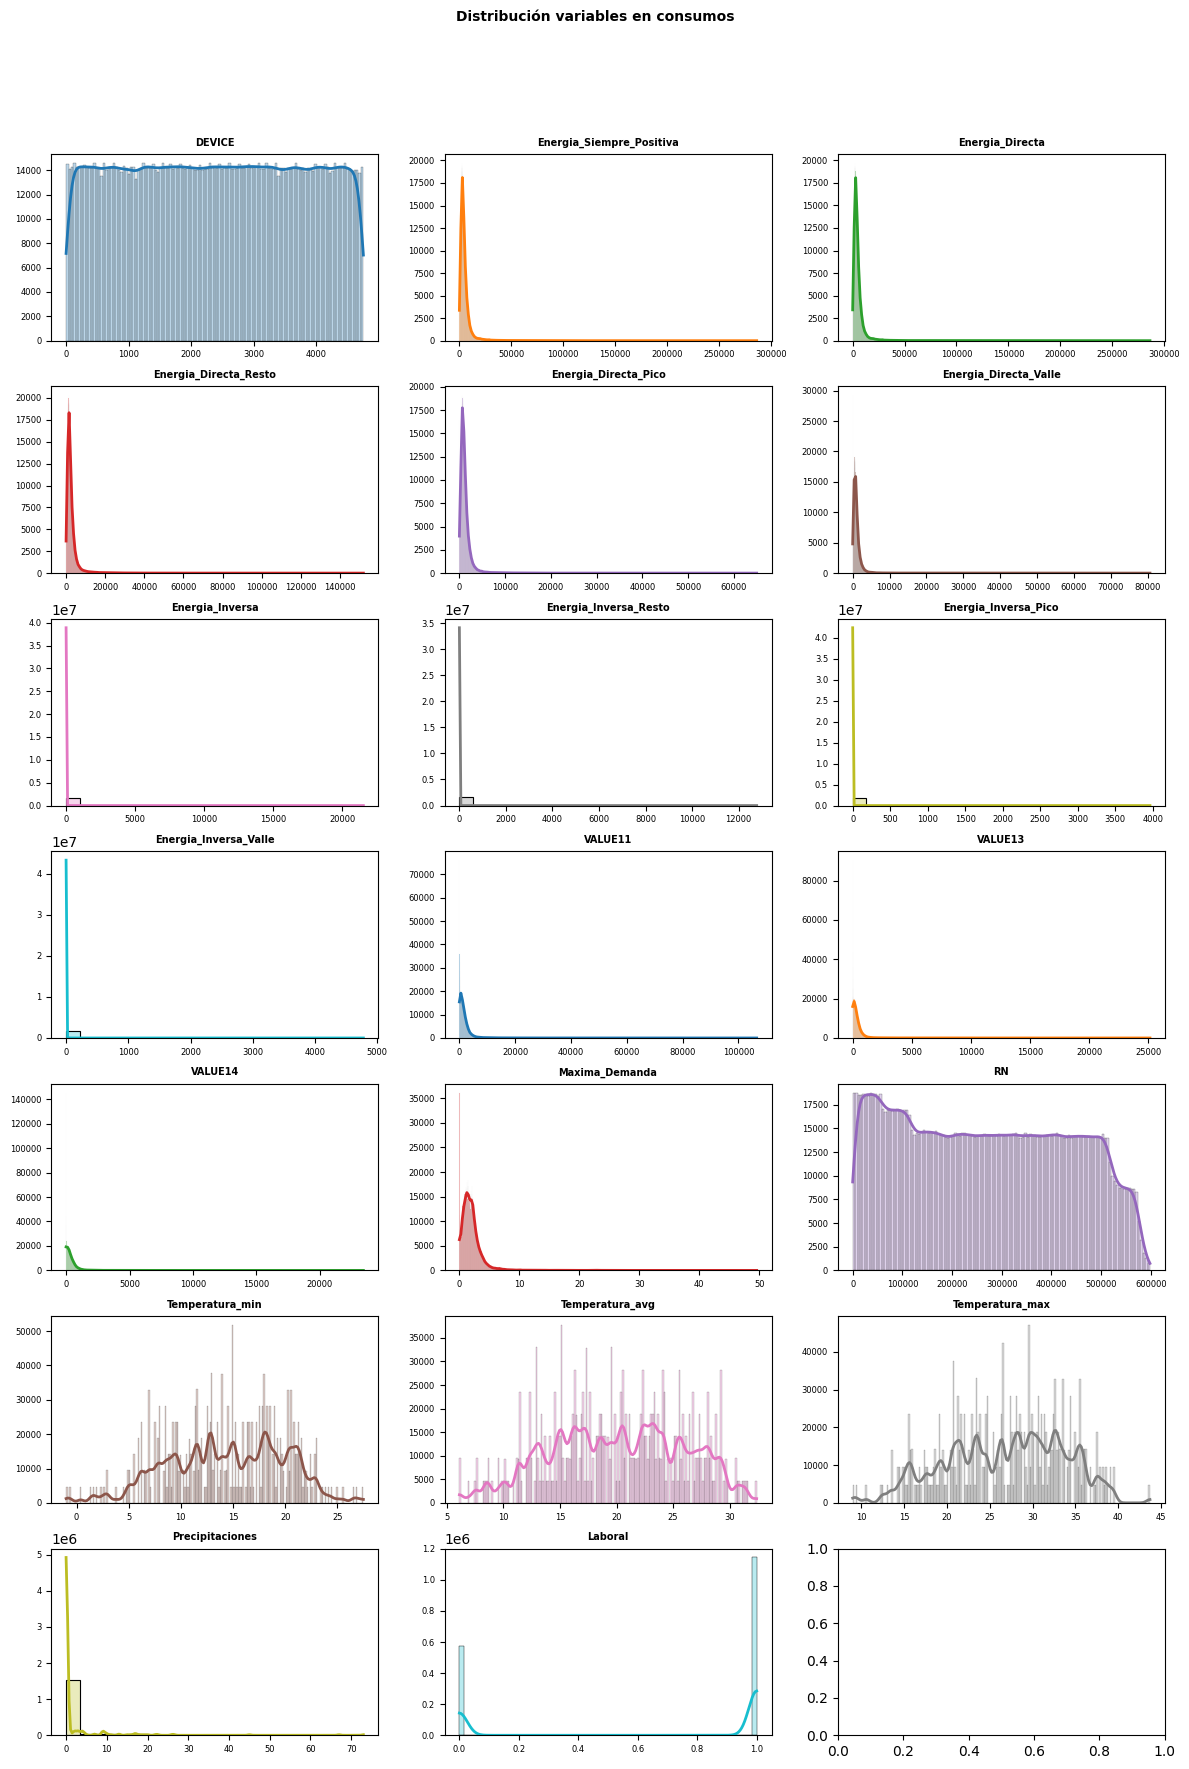

In [42]:
# Gráfico de distribución para cada variable
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(12, 18))
axes = axes.flat
numeric_features = consumos.select_dtypes(include=['float64', 'int64']).columns.tolist()
# son muchas variables elegiremos un subset
numeric_features = ('DEVICE', 'Energia_Siempre_Positiva', 'Energia_Directa', 'Energia_Directa_Resto', 'Energia_Directa_Pico',
 'Energia_Directa_Valle', 'Energia_Inversa', 'Energia_Inversa_Resto', 'Energia_Inversa_Pico', 'Energia_Inversa_Valle',
 'VALUE11', 'VALUE13', 'VALUE14',
 'Maxima_Demanda', 'RN',
 'Temperatura_min', 'Temperatura_avg', 'Temperatura_max', 'Precipitaciones', 'Laboral')

for i, colum in enumerate(numeric_features):
    sns.histplot(
        data    = consumos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables en consumos', fontsize = 10, fontweight = "bold");

¿Cuál es la relación entre las variables disponibles?

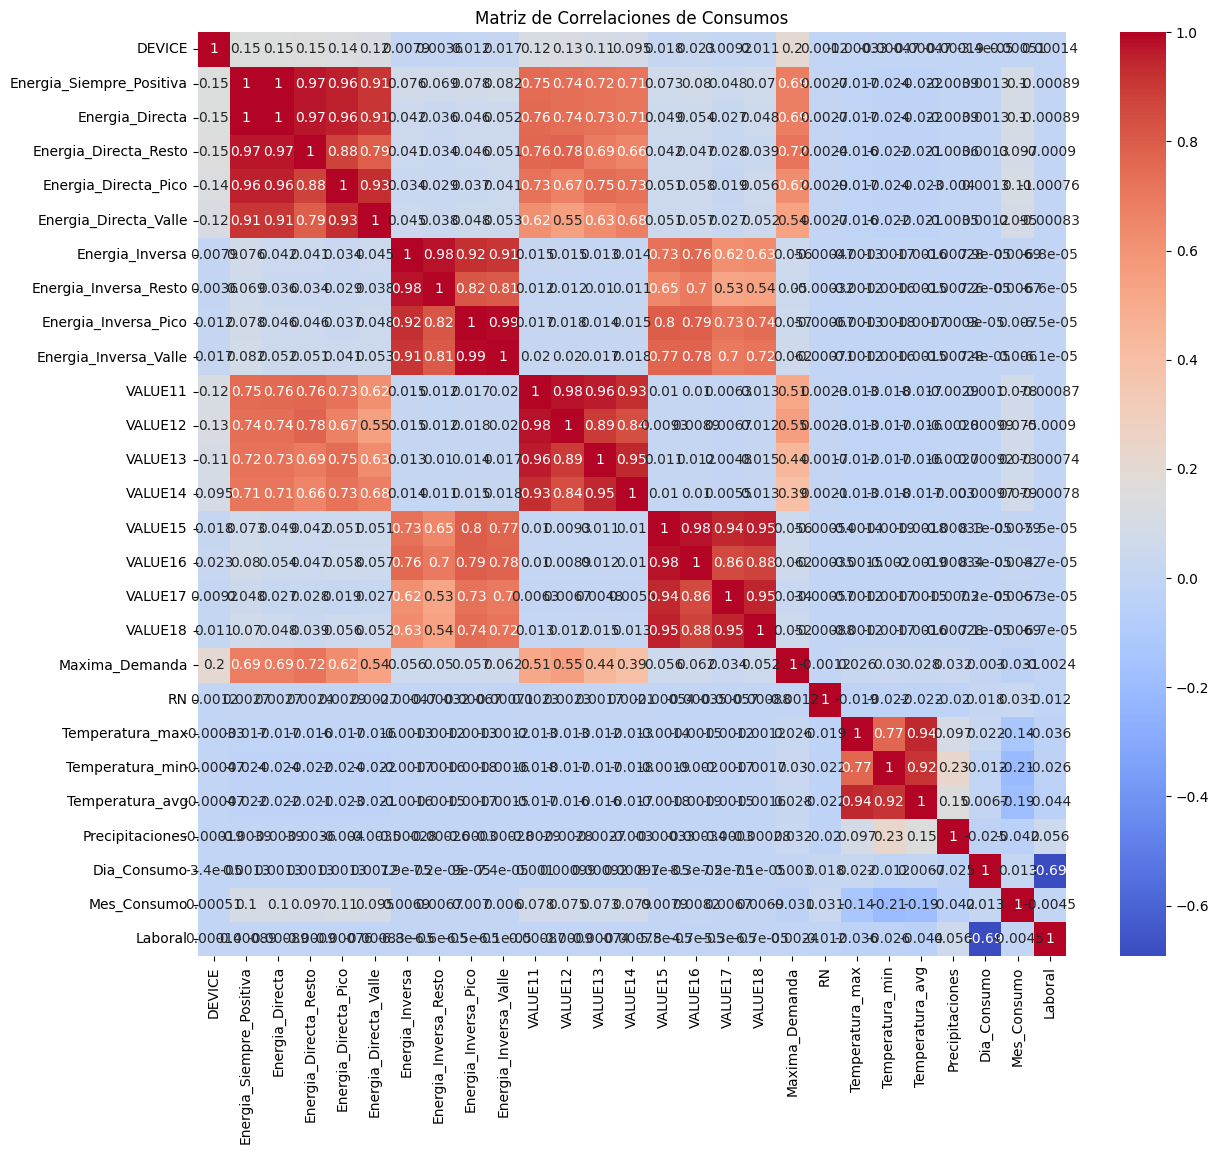

In [43]:
# Matriz de correlaciones
corr_consumos = consumos.corr(numeric_only = True)

# Heatmap
plt.figure(figsize = (14, 12))
sns.heatmap(corr_consumos, annot = True, cmap = 'coolwarm')
plt.title('Matriz de Correlaciones de Consumos')

plt.show()

In [44]:
print('Dataset tiene filas y columnas: ', qgis.shape, '\n')
print('Nombre columnas del dataset: ', '\n', qgis.columns, '\n')
print('Tipo de dato de cada columna: ', '\n', qgis.dtypes , '\n')
print('Descripción estadística: ', '\n', qgis.describe(), '\n')

Dataset tiene filas y columnas:  (4751, 17) 

Nombre columnas del dataset:  
 Index(['DEVICE', 'suministro', 'cliente', 'contrato', 'fecha_inicio', 'sea',
       'distribuidor', 'subestacion', 'zona', 'distrito',
       'distrito_descripcion', 'grupo_lectura', 'ruta_lectura',
       'orden_lectura', 'grupo_tarifario', 'codigo_tarifa', 'tarifa'],
      dtype='object') 

Tipo de dato de cada columna:  
 DEVICE                           int64
suministro                      object
cliente                         object
contrato                         int64
fecha_inicio            datetime64[ns]
sea                             object
distribuidor                    object
subestacion                    float64
zona                            object
distrito                         int64
distrito_descripcion            object
grupo_lectura                   object
ruta_lectura                     int64
orden_lectura                    int64
grupo_tarifario                  int64
codigo_tar

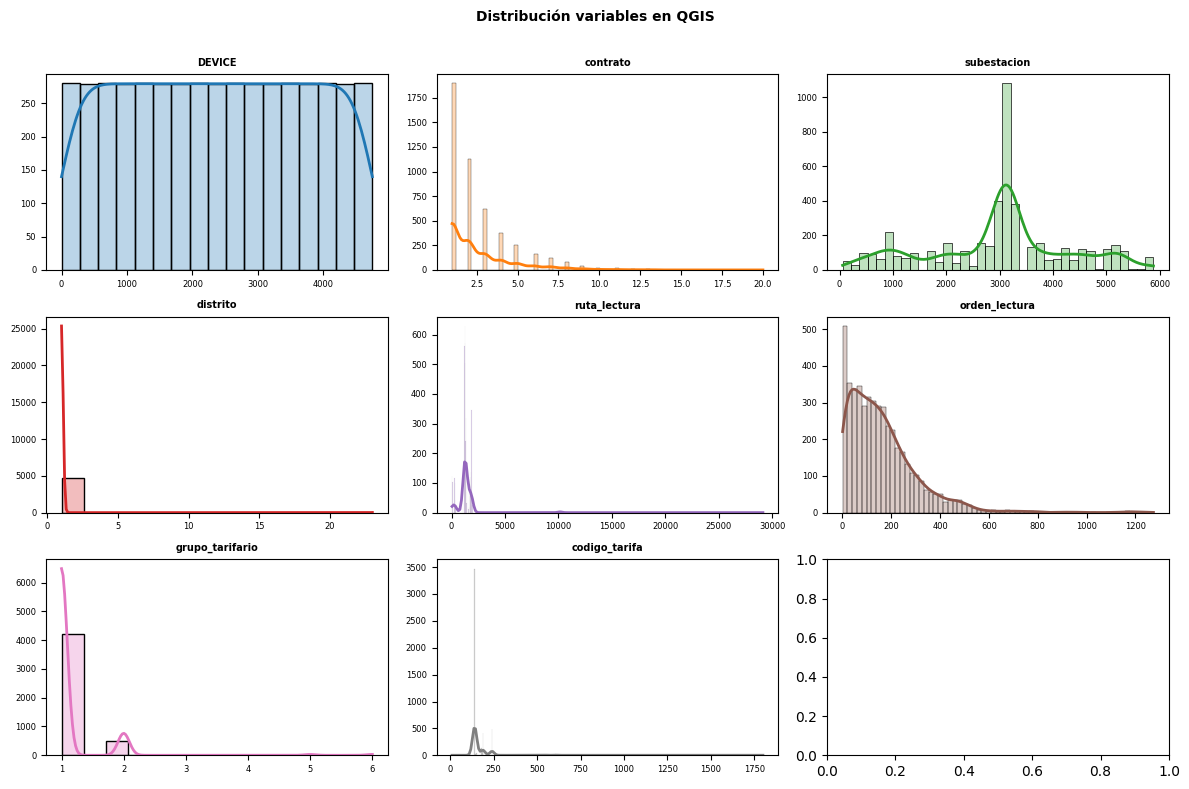

In [45]:
# Gráfico de distribución para cada variable
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flat
numeric_features = qgis.select_dtypes(include=['float64', 'int64']).columns.tolist()

for i, colum in enumerate(numeric_features):
    sns.histplot(
        data    = qgis,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables en QGIS', fontsize = 10, fontweight = "bold");

In [46]:
qgis[numeric_features].corr()

,DEVICE,contrato,subestacion,distrito,ruta_lectura,orden_lectura,grupo_tarifario,codigo_tarifa
DEVICE,1.000000,-0.112211,-0.018497,0.019816,0.085053,0.106779,0.154878,0.123834
contrato,-0.112211,1.000000,-0.049145,0.001891,-0.034872,0.005270,0.042537,0.000476
subestacion,-0.018497,-0.049145,1.000000,0.031888,-0.028278,0.031563,0.036553,0.015501
distrito,0.019816,0.001891,0.031888,1.000000,0.134901,-0.013262,0.006257,0.006290
ruta_lectura,0.085053,-0.034872,-0.028278,0.134901,1.000000,-0.061498,0.504838,0.332511
orden_lectura,0.106779,0.005270,0.031563,-0.013262,-0.061498,1.000000,-0.056272,-0.040088
grupo_tarifario,0.154878,0.042537,0.036553,0.006257,0.504838,-0.056272,1.000000,0.676625
codigo_tarifa,0.123834,0.000476,0.015501,0.006290,0.332511,-0.040088,0.676625,1.000000


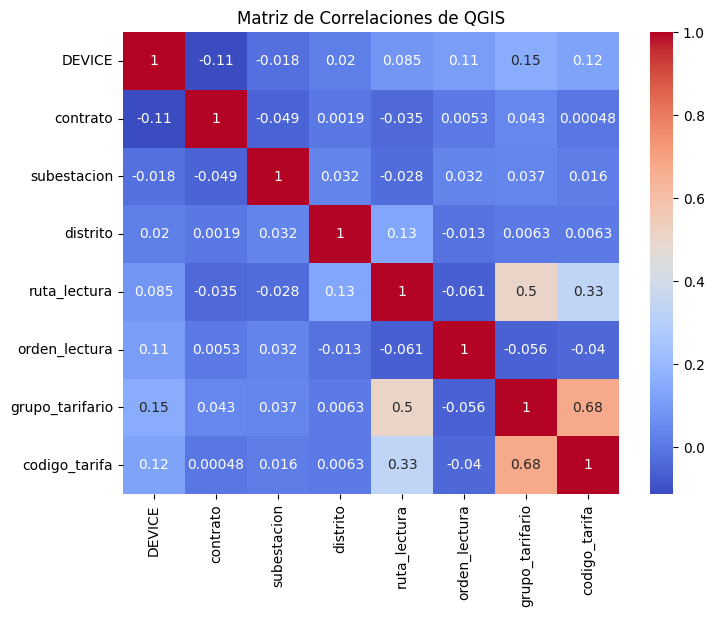

In [47]:
# Matriz de correlaciones
corr_qgis = qgis.corr(numeric_only = True)

# Heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(corr_qgis, annot = True, cmap = 'coolwarm')
plt.title('Matriz de Correlaciones de QGIS')

plt.show()

<Axes: xlabel='grupo_tarifario', ylabel='tarifa'>

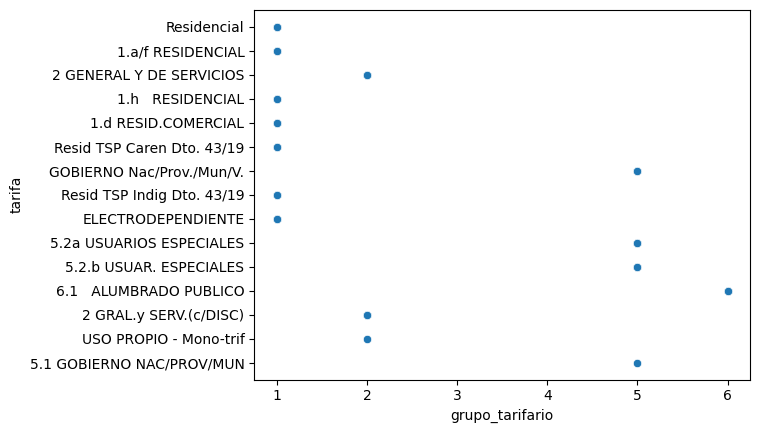

In [48]:
sns.scatterplot(data=qgis, x='grupo_tarifario', y='tarifa')

<Axes: xlabel='grupo_lectura', ylabel='ruta_lectura'>

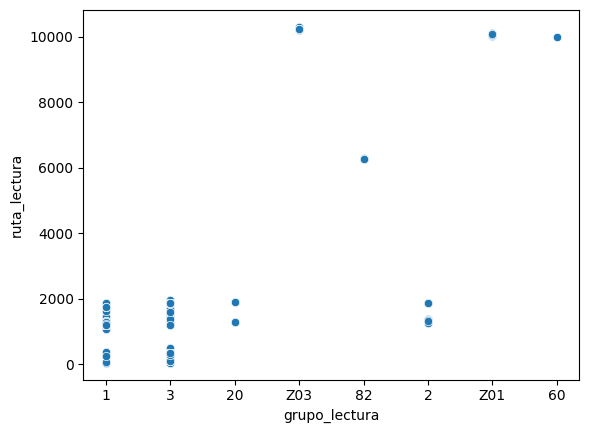

In [49]:
sns.scatterplot(data=qgis, x='grupo_lectura', y='ruta_lectura')

## 5. Objetivo del proyecto:

Establecer un modelo de hábitos de consumo de la energía eléctrica en los tres tramos horarios establecidos por el mercado correlacionados por día hábil (weekday) o fin de semana (weekend), condiciones ambientales (temperatura y humedad) y por tipo tarifario.

Los tramos horarios son resto (5am a 6pm), pico, (6pm a 11pm) y valle (11pm a 5am).

Los hábitos de consumo estarán vinculados además a la demanda contratada con el fin de establecer el factor de uso de la misma.

El modelo establecido deberá tener la capacidad de constituir en un estimador válido de hábitos de consumo para suministros que no posean medidores inteligentes.

Con éste proyecto trataremos de responder algunas de las siguientes preguntas: 

Comportamiento de la demanda:
* Identificar la causa de los picos, valles y consumos medios.
* Identificar como afectan las variables exógenas (temperatura, humedad, lluvia, feriados, vacaciones, días laborales, datos socio económicos, subsidios, etc)
* Identificación de grupos tarifarios
* Predicción de la demanda energética
* Cuales subestaciones se encuentran sobredimensionadas.

---

### 5.1. Creación de la Variable Objetivo

Agregando la variable 'consumo' para el consumo diario de cada medidor. Consumo es el delta de lectura de la Energía entre el período anterior y el período actual. Para determinar el Consumo usaremos  Energia_Directa dado que es el objetivo a estimar.

In [50]:
for medidor in consumos['DEVICE'].unique():
    # Filtramos de 'consumos' para cada 'medidor' ordenando por fecha de consumo
    filtered_consumos = consumos.loc[consumos['DEVICE'] == medidor].sort_values('TV')
        
    # Actualizamos 'consumos[] agregando una columna 'consuno' (en este caso diario) con valores calculados
    consumos.loc[consumos['DEVICE'] == medidor, 'consumo'] = filtered_consumos['Energia_Directa'].diff()
    consumos.loc[consumos['DEVICE'] == medidor, 'consumo_pico'] = filtered_consumos['Energia_Directa_Pico'].diff()
    consumos.loc[consumos['DEVICE'] == medidor, 'consumo_valle'] = filtered_consumos['Energia_Directa_Valle'].diff()
    consumos.loc[consumos['DEVICE'] == medidor, 'consumo_resto'] = filtered_consumos['Energia_Directa_Resto'].diff()

In [51]:
consumos[['consumo','consumo_pico','consumo_valle','consumo_resto']].describe()

,consumo,consumo_pico,consumo_valle,consumo_resto
count,1.713182e+06,1.713182e+06,1.713182e+06,1.713182e+06
mean,9.436336e+00,2.341021e+00,2.065738e+00,5.029577e+00
std,1.850617e+01,4.603079e+00,4.245835e+00,1.114109e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.348000e+00,7.970000e-01,6.620000e-01,1.616000e+00
50%,5.635000e+00,1.403000e+00,1.158000e+00,2.799000e+00
75%,9.792000e+00,2.439000e+00,2.075000e+00,4.974000e+00
max,3.314166e+03,8.711620e+02,8.418830e+02,2.258188e+03


### 5.2. Creación un dataset únificado que llamaremos modelo el cual debería contener solo las variables de interés

Eliminaremos las variables que tienen múltiples representaciones en los dataset, por ejemplo "zona", "distrito" y "distrito_descripcion"

De consumo (es un dataset que ya contiene información metereológica agregada en pasos previos), tomaremos:

In [52]:
features_interesantes_consumo = ['DEVICE', 'TV', 'consumo','consumo_pico','consumo_valle','consumo_resto','Maxima_Demanda','Temperatura_max', 
                                 'Temperatura_min', 'Temperatura_avg', 'Precipitaciones', 'Dia_Consumo', 'Mes_Consumo', 'Laboral']

De qgis, tomaremos:

In [53]:
qgis.columns

Index(['DEVICE', 'suministro', 'cliente', 'contrato', 'fecha_inicio', 'sea',
       'distribuidor', 'subestacion', 'zona', 'distrito',
       'distrito_descripcion', 'grupo_lectura', 'ruta_lectura',
       'orden_lectura', 'grupo_tarifario', 'codigo_tarifa', 'tarifa'],
      dtype='object')

In [54]:
features_interesantes_qgis = ['DEVICE','contrato','grupo_tarifario','zona','sea','distribuidor','subestacion','codigo_tarifa']

Así nuestro modelo contiene...:

In [55]:
modelo = consumos[features_interesantes_consumo]

y también:

In [56]:
modelo = modelo.merge(qgis[features_interesantes_qgis], how='left', on='DEVICE')

Finalmente deberíamos eliminar aquellos atributos que identifican inequivocamente a cada consumidor, puesto que ya tomamos las características generales de ellos (la zona, tipo, tarifa, hábitos de consumo, etc.) y pretendemos un modelo que nos permita generalizar los resultados:

In [57]:
# Debería eliminar la identificación del medidor del modelo
modelo.drop('DEVICE', axis=1, inplace=True)

También deberíamos eliminar fechas en las cuales no tendremos mediciones, por la naturaleza de como se debe realizar el cálculo de la variable objetivo:

In [58]:
# Debería eliminar el 1 de enero de 2023 ya que no tengo forma de estimar su consumo
modelo = modelo.loc[modelo['TV']>'20230101']

Una primer vista de nuestro modelo es:

In [59]:
modelo.sort_values('TV')

,TV,consumo,consumo_pico,consumo_valle,consumo_resto,Maxima_Demanda,Temperatura_max,Temperatura_min,Temperatura_avg,Precipitaciones,Dia_Consumo,Mes_Consumo,Laboral,contrato,grupo_tarifario,zona,sea,distribuidor,subestacion,codigo_tarifa
710990,2023-01-02,4.508,1.064,1.521,1.923,0.484,32.1,15.0,24.5,0.0,0,1,1.0,3,1,A,DBOSCO,13_ACHATEAU,5282.0,190
769117,2023-01-02,5.224,3.035,1.183,1.006,1.340,32.1,15.0,24.5,0.0,0,1,1.0,6,1,A,ARGUE,13_BOULEVARES,2655.0,140
769086,2023-01-02,5.196,1.077,1.317,2.802,0.224,32.1,15.0,24.5,0.0,0,1,1.0,1,1,A,ARGUE,13_BOULEVARES,2655.0,140
769055,2023-01-02,4.586,0.993,1.305,2.288,0.424,32.1,15.0,24.5,0.0,0,1,1.0,1,1,A,ARGUE,13_VBELGRANO,3060.0,140
769024,2023-01-02,17.692,2.985,5.010,9.697,3.632,32.1,15.0,24.5,0.0,0,1,1.0,2,1,A,ARGUE,13_VBELGRANO,3060.0,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255827,2023-12-31,6.060,1.211,1.973,2.876,1.684,32.3,20.2,25.1,73.0,6,12,0.0,4,1,A,ARGUE,13_LOSHUNGAROS,3047.0,140
1150359,2023-12-31,0.579,0.122,0.167,0.290,0.820,32.3,20.2,25.1,73.0,6,12,0.0,3,1,A,CERRO,13_CROLASROSAS,3025.0,140
1142845,2023-12-31,2.862,0.599,0.764,1.499,0.960,32.3,20.2,25.1,73.0,6,12,0.0,1,1,A,DFUNES,13_OPERA,4648.0,140
1164215,2023-12-31,15.818,0.910,3.379,11.529,2.292,32.3,20.2,25.1,73.0,6,12,0.0,13,1,A,DFUNES,13_CARAFA,1321.0,140


Ya observamos que deberíamos agrupar para una misma fecha de consumo los registros que contengan los mismos atribitos. Estos es:

* Debería hacer un group by TV (fecha) para sumar todas las filas del mismo día
* agrupando por grupo_tarifario, subestacion, y codigo_tarifa
* y las variables sobre y demanda se deberían agregar o sumar para todos los registros, puesto que se trata de la demanda sumada de distintos usuarios.
* pero la variable contratos, que indica la cantidad de veces que se firmó un contrato en un medidor determinado, debería promediarse, para que tenga sentido el dato.

In [60]:
# Debería hacer un group by TV (fecha) para sumar todas las filas del mismo día, agrupando por grupo_tarifario, subestacion, y codigo_tarifa
# sumando los consumos, sumando Maxima_Demanda, y el promedio de contratos.
modelo = modelo.groupby(by=['TV','grupo_tarifario','zona','sea','distribuidor','subestacion','codigo_tarifa','Temperatura_max','Temperatura_min','Temperatura_avg','Precipitaciones','Dia_Consumo','Mes_Consumo','Laboral'], as_index=False).agg({"consumo" : sum, "consumo_pico" : sum, "consumo_valle" : sum, "consumo_resto" : sum, 'Maxima_Demanda' : sum, 'contrato' : "mean"})

ya tenemos un dataset con nuestro modelo inicial, ahora podemos intentar buscar las respuestas

---

## 6. Análisis del modelo

### 6.1. Identificar la causa de los picos, valles y consumos medios.

In [61]:
consumo_tramo_horario = modelo.groupby(['TV'], as_index=False)[['consumo_pico','consumo_valle','consumo_resto']].sum()

In [62]:
#Usamos la función melt para desvincular de; formato ancho a largo.
consumo_tramo_horario = pd.melt(consumo_tramo_horario, ['TV'], var_name='tipo_consumo', value_name='kwh')

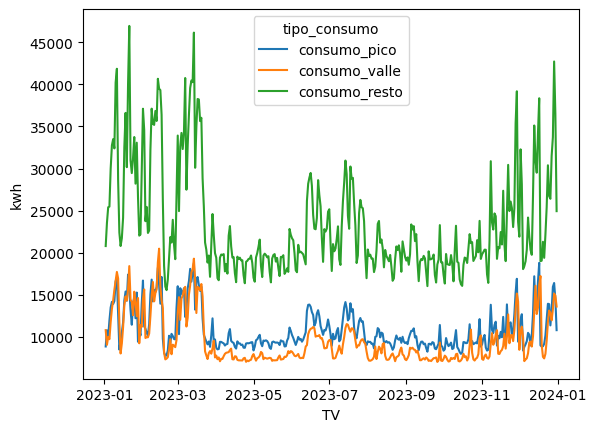

In [63]:
sns.lineplot(data=consumo_tramo_horario, x='TV', y='kwh', hue='tipo_consumo')
plt.show()

### 6.2. Identificación de consumos por grupo tarifario

In [64]:
# Hago un groupby: grupo_tarifario para plotear
consumo_grupo_tarifario = modelo.groupby(['TV','grupo_tarifario','Temperatura_max','Temperatura_min','Temperatura_avg','Precipitaciones','Dia_Consumo','Mes_Consumo','Laboral'], as_index=False)[['consumo','Maxima_Demanda']].sum()

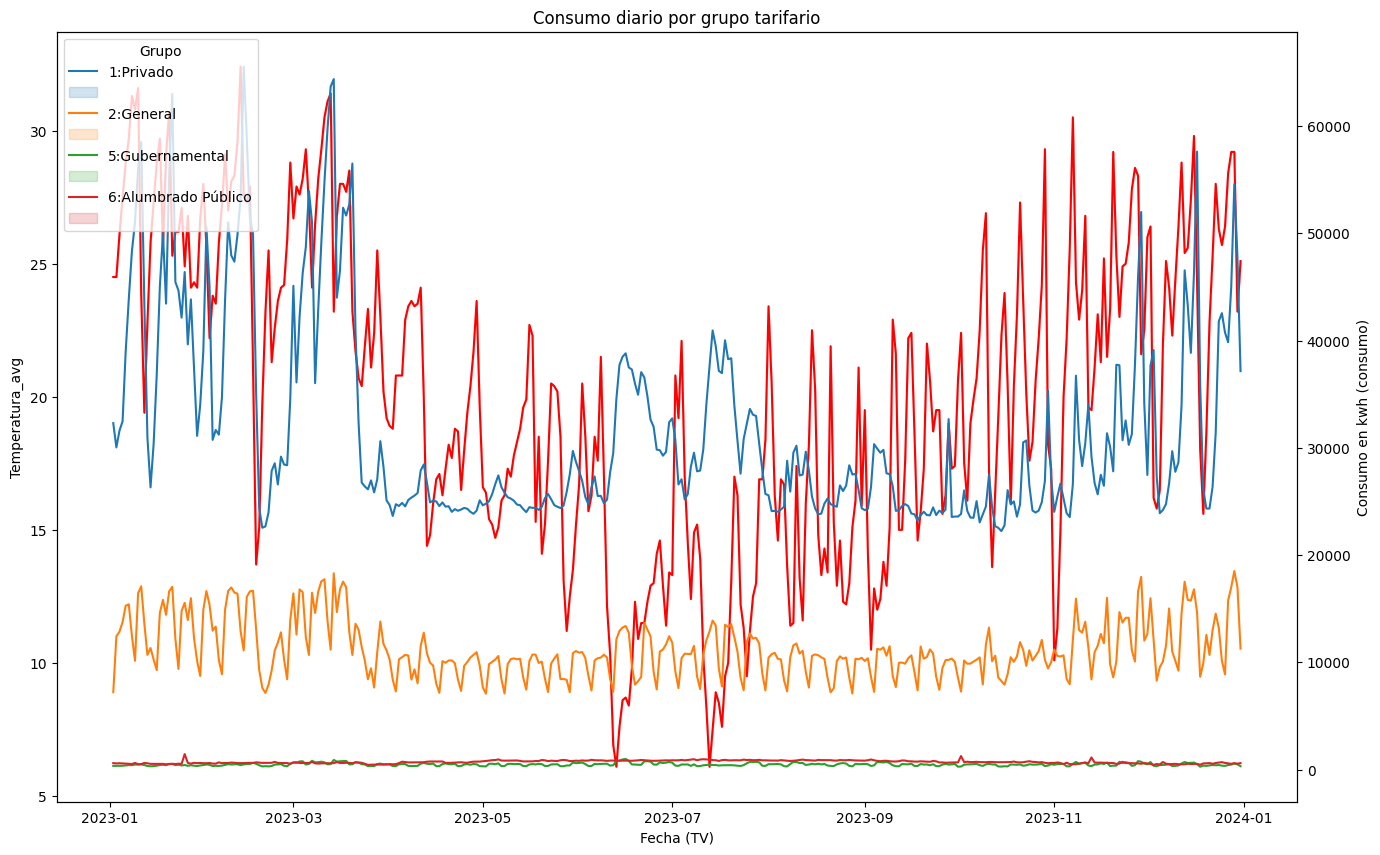

In [65]:
# Identificar la causa de los picos, valles y consumos medios.

fig, ax = plt.subplots(figsize=(16, 10))

# Variable: Temperatura
sns.lineplot(x="TV", y="Temperatura_avg",
             data=consumo_grupo_tarifario, ax=ax, color='red')
ax2 = ax.twinx()

# Target: consumo
sns.lineplot(x="TV", y="consumo",
             hue="grupo_tarifario",
             data=consumo_grupo_tarifario, ax=ax2, palette=sns.color_palette())

# Referencias
ax.set(xlabel='Fecha (TV)',
       title='Consumo diario por grupo tarifario')
ax2.set(ylabel='Consumo en kwh (consumo)')
plt.legend(title='Grupo', loc='upper left', labels=['1:Privado', '','2:General','', '5:Gubernamental', '','6:Alumbrado Público',''])
plt.show()

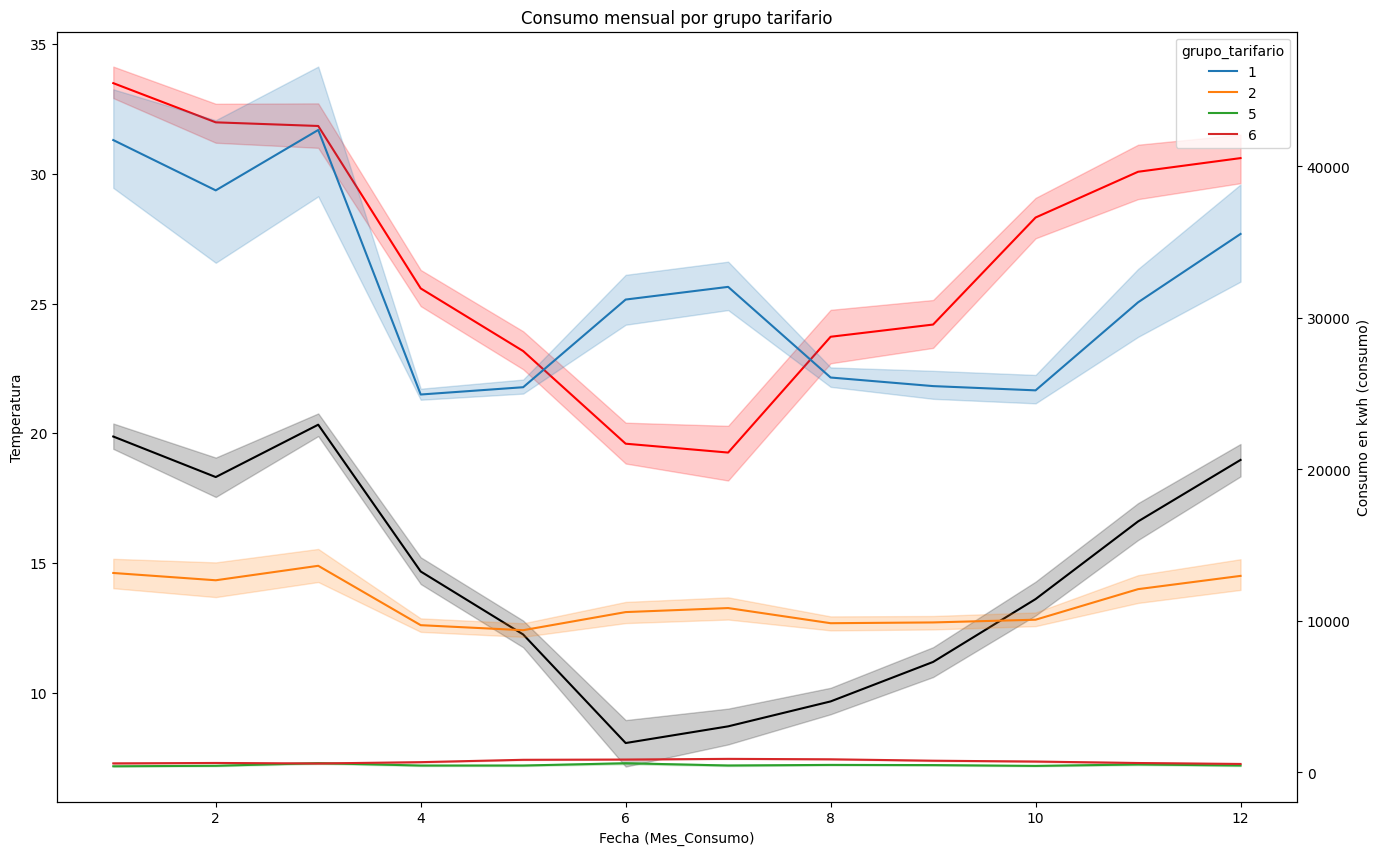

In [66]:
# Identificar la causa de los picos, valles y consumos medios.

fig, ax = plt.subplots(figsize=(16, 10))

# Variable: Temperatura Máxima
sns.lineplot(x="Mes_Consumo", y="Temperatura_max",
             data=consumo_grupo_tarifario, ax=ax, color='red')

# Variable: Temperatura Mínima
sns.lineplot(x="Mes_Consumo", y="Temperatura_min",
             data=consumo_grupo_tarifario, ax=ax, color='black')
ax2 = ax.twinx()

# Consumo
sns.lineplot(x="Mes_Consumo", y="consumo",
             hue="grupo_tarifario", 
             data=consumo_grupo_tarifario, ax=ax2, palette=sns.color_palette())

# Referencias
ax.set(xlabel='Fecha (Mes_Consumo)',
       ylabel='Temperatura',
       title='Consumo mensual por grupo tarifario')
ax2.set(ylabel='Consumo en kwh (consumo)')

plt.show()

### 6.3 Datos meterológicos

In [108]:
modelo_meterologico = modelo[['TV','Precipitaciones','Temperatura_avg','Temperatura_min','Temperatura_max','Mes_Consumo','Dia_Consumo']]
modelo_meterologico['Dia'] = modelo_meterologico.TV.dt.day

Con esta función podemos visualizar las variables metereológicas dándoles un color que nos permita una interpretación más rápida

In [ ]:
def plot_heatmap(df, title):
    plt.figure(figsize = (10, 8))
    ax = sns.heatmap(df, cmap='RdYlGn_r',
                     robust=True,
                     fmt='.2f', annot=True,
                     linewidths=.5, annot_kws={'size':10},
                     cbar_kws={'shrink':.8, 'label':title})
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
    plt.title(title, fontdict={'fontsize':14}, pad=14);

Visualizamos nuestras variables:

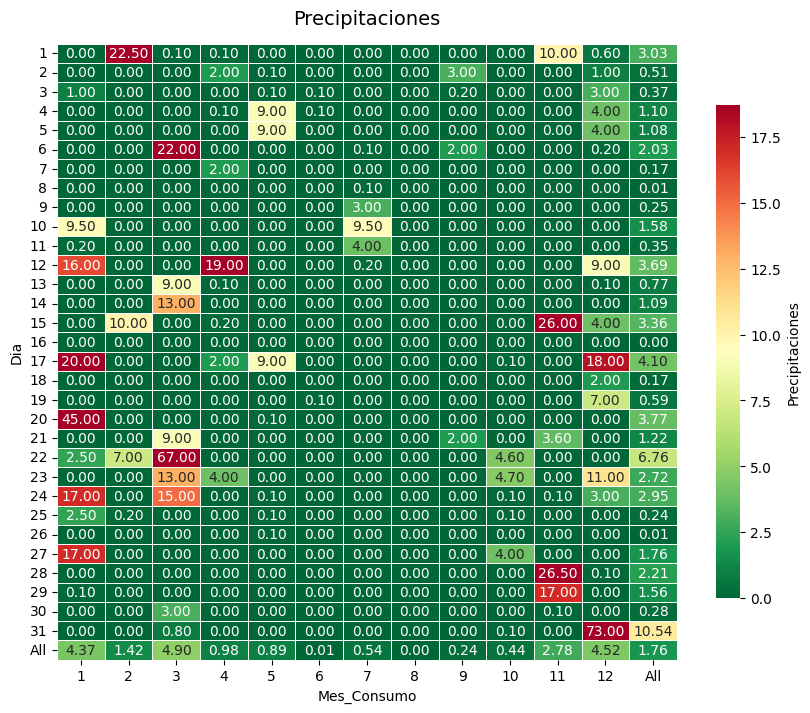

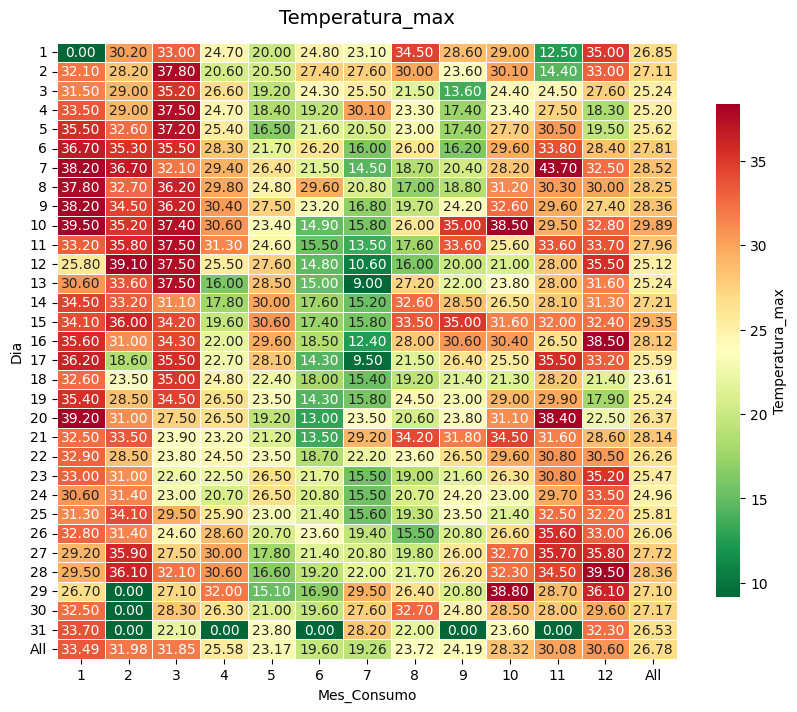

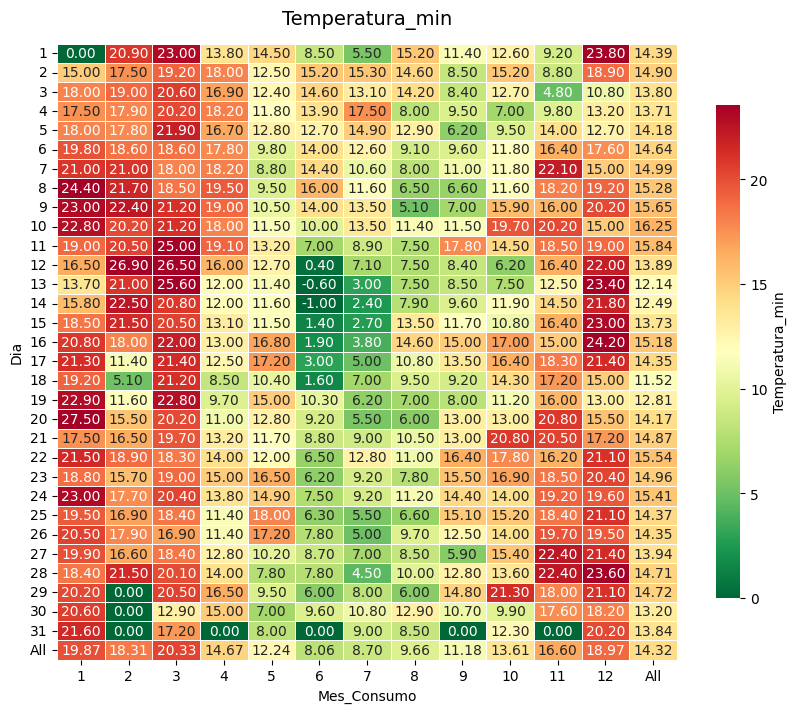

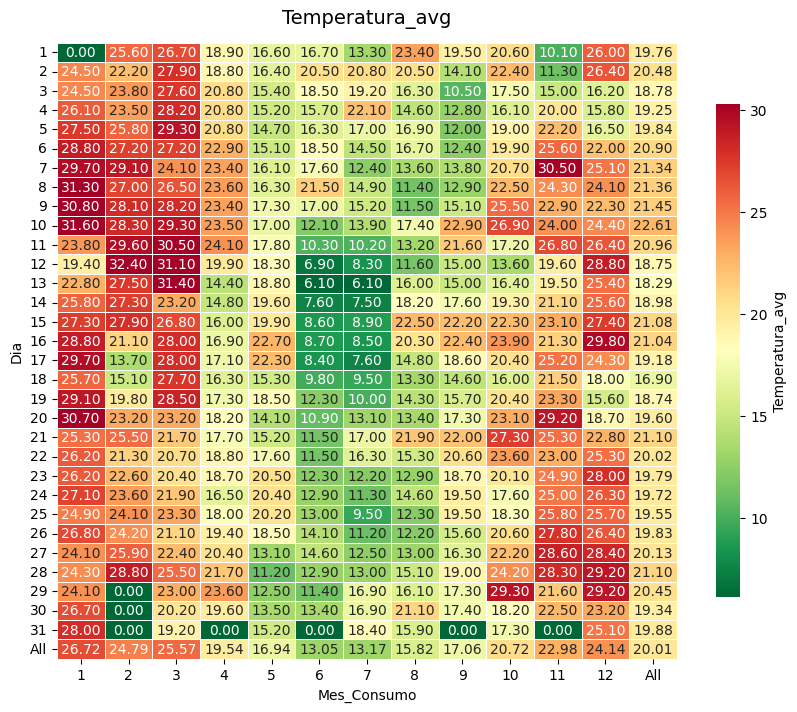

In [112]:
for variable_meterologica in ('Precipitaciones','Temperatura_max','Temperatura_min','Temperatura_avg'):
    calendario_meterologico = pd.pivot_table(modelo_meterologico[['TV','Temperatura_max','Temperatura_min','Temperatura_avg','Precipitaciones','Mes_Consumo','Dia','Dia_Consumo']], 
                          values= variable_meterologica ,index=['Dia'],
                                   columns=['Mes_Consumo'],
                                   fill_value=0,
                                   margins=True)
    plot_heatmap(calendario_meterologico, variable_meterologica)

### 6.4 Estimación básica inicial de la demanda

Regresión lineal para la predicción de la demanda energética

In [67]:
# Predicción de la demanda energética
from sklearn.model_selection import train_test_split

target = 'consumo'

x = modelo.drop(target, axis=1)
x = x.drop(['TV','zona','sea','distribuidor','subestacion','consumo_pico', 'consumo_valle', 'consumo_resto'], axis=1)
y = modelo[target]

x_train , x_test , y_train , y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

In [68]:
# División el dataset
print('Entrenamiento: ', x_train.shape, y_train.shape,'\nTesting: ',x_test.shape, y_test.shape)

Entrenamiento:  (325630, 11) (325630,) 
Testing:  (139556, 11) (139556,)


In [69]:
# Creación del modelo
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(f"Coeficientes: {model.coef_}")

Coeficientes: [ 5.68289836  0.00683841  0.17926063  0.5096133  -0.13568819  0.01913136
  0.6584224  -0.2727465   3.72325829  4.31465703  0.99907996]


In [70]:
model

LinearRegression()

In [71]:
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score, classification_report, confusion_matrix

# Evaluación del modelo
m2e = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {m2e}")
print(f"R2 score: {r2}")

Mean squared error: 989.4664183165756
R2 score: 0.596806124969607


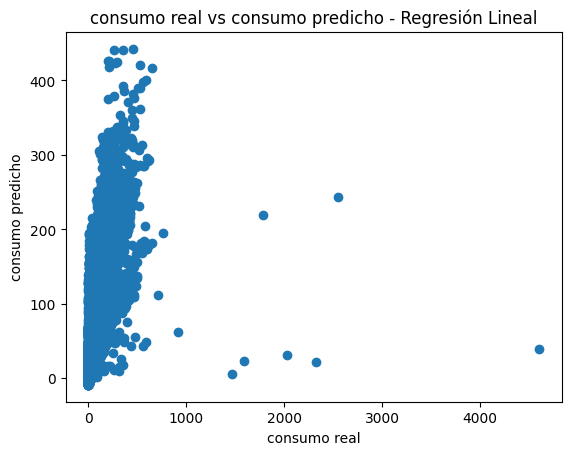

In [72]:
# Graficamos los resultados
plt.scatter(y_test, y_pred)
plt.xlabel(target+' real')
plt.ylabel(target+' predicho')
plt.title(target+' real vs '+target+' predicho - Regresión Lineal')
plt.show()